In [ ]:
# ! cp drive/My\ Drive/CT.zip .
# ! unzip CT.zip

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import nibabel as nib
from tqdm.notebook import tqdm
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

from medpy.io import load
from medpy.io import save

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pandas as pd
import os
import shutil
import copy

ngpu = torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device, ngpu)

cuda:0 1


In [3]:
class Prior_Spine(Dataset):
    def __init__(self, root, imgdir, labeldir, labeldir_left, labeldir_right, device):
        self.root = root
        self.imgdir = imgdir
        self.labeldir = labeldir
        self.labeldir_left = labeldir_left
        self.labeldir_right = labeldir_right
        self.img_fn = [f for f in sorted(os.listdir(root+imgdir)) if f.endswith('.npy')]
        self.seg_fn = [f for f in sorted(os.listdir(root+labeldir)) if f.endswith('.npy')]
        self.seg_left = [f for f in sorted(os.listdir(root+labeldir_left)) if f.endswith('.npy')]
        self.seg_right = [f for f in sorted(os.listdir(root+labeldir_right)) if f.endswith('.npy')]
        
        self.prior_dir = '/home/rahul/MIG/M.Tech/Code/Segmentation_DA_MSD/data/SpineCT_processed/train/prior/'
        self.prior_fn = [f for f in sorted(os.listdir(self.prior_dir+'complete/')) if f.endswith('.npy')]
        # self.prior = torch.from_numpy(prior).unsqueeze(dim=0).type(torch.FloatTensor)
        # prior_left = copy.deepcopy(prior)
        # prior_right = copy.deepcopy(prior)
        # prior_full = copy.deepcopy(prior)
        # prior_left[prior_left==2] = 0
        # prior = torch.from_numpy(prior).unsqueeze(dim=0).type(torch.FloatTensor)
        # self.prior_left = torch.from_numpy(prior_left).unsqueeze(dim=0).type(torch.FloatTensor)
        
        # prior_right[prior_right==1] = 0
        # prior_right[prior_right==2] = 1
        # self.prior_right = torch.from_numpy(prior_right).unsqueeze(dim=0).type(torch.FloatTensor)
        
        # prior_full[prior_full==2] = 1
        # self.prior_full = torch.from_numpy(prior_full).unsqueeze(dim=0).type(torch.FloatTensor)

        # self.datalist = []
        
        # for i, (img_file, seg_file, seg_left_file, seg_right_file) in enumerate(zip(img_fn, seg_fn, seg_left, seg_right)):

        #     filename_img = os.path.join(root, imgdir, img_file)
        #     filename_seg_full = os.path.join(root, labeldir, seg_file)
        #     filename_seg_left = os.path.join(root, labeldir_left, seg_left_file)
        #     filename_seg_right = os.path.join(root, labeldir_right, seg_right_file)

        #     assert img_file.replace('.','_').split('_')[1] == seg_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
        #     assert img_file.replace('.','_').split('_')[1] == seg_left_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
        #     assert img_file.replace('.','_').split('_')[1] == seg_right_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            
        #     seg_img_data = np.load(filename_seg_full)
        #     seg_left = np.load(filename_seg_left)
        #     seg_right = np.load(filename_seg_right)
        #     img_data = np.load(filename_img)

        #     output = np.unique(seg_img_data, return_counts=True)
        #     counts = output[1]
        #     if i==0:
        #         weights = counts
        #     else:
        #         weights += counts


        #     assert img_data.shape == seg_img_data.shape, "Image and Labels have different shapes"
        #     assert img_data.shape == seg_left.shape, "Image and Labels have different shapes"
        #     assert img_data.shape == seg_right.shape, "Image and Labels have different shapes"
            
        #     for j in range(img_data.shape[2]):
        #         image2d = torch.from_numpy(img_data[:,:,j]).unsqueeze(dim=0).type(torch.FloatTensor)
        #         label2d = torch.from_numpy(seg_img_data[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
        #         label_left = torch.from_numpy(seg_left[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
        #         label_right = torch.from_numpy(seg_right[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                
        #         cat_full = torch.cat((image2d, prior), axis=0)
        #         cat_left = torch.cat((image2d, prior_left), axis=0)
        #         cat_right = torch.cat((image2d, prior_right), axis=0)

        #         if (len(torch.unique(label2d))>=2):
        #                 self.datalist.append([ cat_full, cat_left, cat_right, image2d , label2d , label_left, label_right])
        # self.weights = torch.Tensor(weights)
        # self.weights = torch.sum(self.weights) - self.weights
        # self.weights = self.weights / torch.sum(self.weights)

    def __getitem__(self, index):
        prior_left_fn = os.path.join(self.prior_dir, 'left', self.prior_fn[index])
        prior_left = torch.from_numpy(np.load(prior_left_fn)).unsqueeze(dim=0).type(torch.FloatTensor)
        prior_right_fn = os.path.join(self.prior_dir, 'right', self.prior_fn[index])
        prior_right = torch.from_numpy(np.load(prior_right_fn)).unsqueeze(dim=0).type(torch.FloatTensor)
        prior_full_fn = os.path.join(self.prior_dir, 'full', self.prior_fn[index])
        prior_full = torch.from_numpy(np.load(prior_full_fn)).unsqueeze(dim=0).type(torch.FloatTensor)
        prior_comp_fn = os.path.join(self.prior_dir, 'complete', self.prior_fn[index])
        prior_comp = torch.from_numpy(np.load(prior_comp_fn)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_img = os.path.join(self.root, self.imgdir, self.prior_fn[index])
        img =  torch.from_numpy(np.load(filename_img)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg = os.path.join(self.root, self.labeldir,self.prior_fn[index])
        seg =  torch.from_numpy(np.load(filename_seg)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg_left = os.path.join(self.root, self.labeldir_left, self.prior_fn[index])
        seg_left =  torch.from_numpy(np.load(filename_seg_left)).unsqueeze(dim=0).type(torch.FloatTensor)
        filename_seg_right = os.path.join(self.root, self.labeldir_right, self.prior_fn[index])
        seg_right =  torch.from_numpy(np.load(filename_seg_right)).unsqueeze(dim=0).type(torch.FloatTensor)
        seg_full = copy.deepcopy(seg)
        seg_full[seg_full==2]=1
        
        cat_full = torch.cat((img, prior_full), axis=0)
        cat_left = torch.cat((img, prior_left), axis=0)
        cat_right = torch.cat((img, prior_right), axis=0)
        cat_hip = torch.cat((img, prior_comp), axis=0)
        # cat_hip[cat_hip==2]=1
        # [ cat_full, cat_left, cat_right, img, seg, seg_left, seg_right] = self.datalist[index]
        
        return {'cat_hip' : cat_hip, 'cat_full' : cat_full, 'cat_left' : cat_left, 'cat_right' : cat_right, \
            'img' : img, 'seg' : seg, 'seg_left' : seg_left, 'seg_right' : seg_right, 'seg_full' : seg_full}

    def __len__(self):
        return len(self.prior_fn)

In [2]:
class Prior(Dataset):
    def __init__(self, root, imgdir, labeldir1, labeldir2, labeldir3, labeldir4, slices=1, train_ratio = 1):
        self.slices = slices
        assert self.slices % 2 == 1, "slices must be odd!"
        es = int(self.slices/2) # floor operation
        img_fn = [f for f in sorted(os.listdir(root+imgdir)) if f.endswith('.npy')]
        seg_fn = [f for f in sorted(os.listdir(root+labeldir1)) if f.endswith('.npy')]
        seg_left = [f for f in sorted(os.listdir(root+labeldir2)) if f.endswith('.npy')]
        seg_right = [f for f in sorted(os.listdir(root+labeldir3)) if f.endswith('.npy')]
        seg_complete = [f for f in sorted(os.listdir(root+labeldir4)) if f.endswith('.npy')]
        self.datalist = []
        # prior = torch.from_numpy(np.load('priors/'+str(train_ratio)+'.npy'))
        # prior = prior.unsqueeze(dim=0).type(torch.FloatTensor)
        for i, (img_file, seg_file, seg_file2, seg_file3, seg_file4) in enumerate(zip(img_fn, seg_fn, seg_left, seg_right, seg_complete)):

            filename_img = os.path.join(root, imgdir, img_file)
            filename_seg_full = os.path.join(root, labeldir1, seg_file)
            filename_seg_left = os.path.join(root, labeldir2, seg_file2)
            filename_seg_right = os.path.join(root, labeldir3, seg_file3)
            filename_seg_complete = os.path.join(root, labeldir4, seg_file4)

            assert img_file.replace('.','_').split('_')[1] == seg_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_file2.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_file3.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_file4.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            
            seg_img_data = np.load(filename_seg_full)
            seg_img_left = np.load(filename_seg_left)
            seg_img_right = np.load(filename_seg_right)
            seg_img_complete = np.load(filename_seg_complete)
            img_data = np.load(filename_img)

            assert img_data.shape == seg_img_data.shape, "Image and Labels have different shapes"
            assert img_data.shape == seg_img_left.shape
            assert img_data.shape == seg_img_right.shape
            assert img_data.shape == seg_img_complete.shape
            
            for j in range(img_data.shape[2]):
                image2d = torch.from_numpy(img_data[:,:,j]).unsqueeze(dim=0).type(torch.FloatTensor)
                label2d = torch.from_numpy(seg_img_data[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                label2d2 = torch.from_numpy(seg_img_left[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                label2d3 = torch.from_numpy(seg_img_right[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                label2d4 = torch.from_numpy(seg_img_complete[:,:,j]).unsqueeze(dim=0).type(torch.LongTensor)
                # print(image2d.shape, label2d.shape, label2d2.shape)
                if (len(torch.unique(label2d))>=2):
                    self.datalist.append([ image2d , label2d, label2d2, label2d3, label2d4 ])

    def __getitem__(self, index):
        [ img, seg, seg2, seg3, seg4] = self.datalist[index]
#         return {"A": img, "B": seg}
        return [img, seg, seg2, seg3, seg4]

    def __len__(self):
        return len(self.datalist)

In [7]:
root_dir = '../data/SpineCT_processed/train/'
imgdir = 'imagesTr'
labeldir = 'prior/complete'
labeldir_2 = 'prior/left'
labeldir_3 = 'prior/right'
labeldir_4 = 'prior/complete'

validation_split = 0.2
shuffle_dataset = True
random_seed= 42
batch_size = 2
train_ratio = 1

dataset = Prior_Spine(root = root_dir, imgdir = imgdir, labeldir = labeldir, labeldir_left = labeldir_3, labeldir_right = labeldir_4, device = torch.device('cuda:0'))

np.random.seed(0)
torch.manual_seed(0)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# print(train_indices, val_indices)

In [32]:
# train_indices[0:int(0.3*len(train_indices))]
# train_indices[0:, int(0.3*len(train_indices))]

In [8]:
train_ratio = 1.0
np.random.seed(0)
torch.manual_seed(0)

train_sampler = SubsetRandomSampler(train_indices[0:int(train_ratio*len(train_indices))])
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
n_train = len(train_loader)
n_val = len(validation_loader)
a = iter(train_loader)
batch = a.next()
print(len(batch), n_train, n_val)

9 3281 820


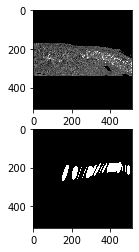

In [17]:
# print(np.unique(dataset[10][2]))
fig = plt.figure()
plt.subplot(2,1,1).imshow(dataset[150]['img'].squeeze().numpy(), cmap='gray')
plt.subplot(2,1,2).imshow(dataset[500]['seg'].squeeze().numpy(), cmap='gray')
plt.show()

In [18]:
class MyConvTranspose2d(nn.Module):
    def __init__(self, conv):
        super(MyConvTranspose2d, self).__init__()
#         self.output_size = output_size
        self.conv = conv
        
    def forward(self, x, output_size):
        x = self.conv(x, output_size=output_size)
        return x
    
class conv_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_filters, (3, 3), padding=1)
        self.conv1_bn = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv2_bn = nn.BatchNorm2d(num_filters) 
    
    def forward(self, inp_tensor):
        encoder = self.conv1(inp_tensor)
        encoder = self.conv1_bn(encoder)
        encoder = torch.relu(encoder)
        encoder = self.conv2(encoder)
        encoder = self.conv2_bn(encoder)
        encoder = torch.relu(encoder)
        return encoder

class encoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(encoder_block, self).__init__()
        self.conv_block1 = conv_block(num_channels, num_filters)
        self.max_pool1 = nn.MaxPool2d((2, 2), (2, 2))
    
    def forward(self, inp_tensor):
        encoder = self.conv_block1(inp_tensor)
        encoder_pool = self.max_pool1(encoder)
        return (encoder_pool, encoder)

class decoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(decoder_block, self).__init__()
        conv = nn.ConvTranspose2d(num_channels, num_filters, (2, 2), stride=(2, 2))
        self.conv_tp1 = MyConvTranspose2d(conv)
        self.conv_tp1_bn = nn.BatchNorm2d(2*num_filters)
        self.conv_tp2 = nn.Conv2d(2*num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp2_bn = nn.BatchNorm2d(num_filters)
        self.conv_tp3 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp3_bn = nn.BatchNorm2d(num_filters)

    def forward(self, inp_tensor, concat_tensor, output_size):
        decoder = self.conv_tp1(inp_tensor,output_size=output_size)
        decoder = torch.cat((concat_tensor, decoder), 1)
        decoder = self.conv_tp1_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp2(decoder)
        decoder = self.conv_tp2_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp3(decoder)
        decoder = self.conv_tp3_bn(decoder)
        decoder = torch.relu(decoder)
        return decoder

In [19]:
class UNet2D(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super(UNet2D, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
#         self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
#         self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
    
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
#         encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8

        center = self.center(encoder3_pool) # center (8)

#         decoder4 = self.decoder_block4(center, encoder4) # 16
        
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [31]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    # print(y_true.shape, y_pred.shape)
    # assert y_true.shape == y_pred.shape, "Tensor dimensions must match"
    shape = y_true.shape
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = torch.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (torch.sum(y_true_flat) + torch.sum(y_pred_flat) + smooth)
    return score

def dice_coeff_multiclass(y_true, y_pred, num_classes):
    dice = []
    output = torch.argmax(y_pred, dim=1)
    y_true = y_true.squeeze(0)
    # print(torch.unique(y_true), torch.unique(output))
    # print(output.shape, y_true.shape)
    for i in range(num_classes):
        segs = y_true.clone().detach()
        segs[y_true==i]=1
        segs[y_true!=i]=0
        # print(torch.unique(segs==y_true))
        outs = output.clone().detach()
        outs[output==i]=1
        outs[output!=i]=0
        # print(torch.unique(outs==output))
        dice.append(dice_coeff(segs, outs).item())
    # print(dice)
    return dice, output, y_true

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model..unsqueeze(0)
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def bce_dice_loss(y_true, y_pred):
    loss = F.binary_cross_entropy(y_pred, y_true) + dice_loss(y_true, y_pred)
    return loss

def cross_ent_dice_loss(y_true, y_pred):
    # print(y_true.shape, y_pred.shape)
    loss = nn.CrossEntropyLoss
    # y_pred = torch.argmax(y_pred, 1)
    
    loss = F.cross_entropy(y_pred.float(), y_true) + dice_loss(y_true, y_pred)
    return loss

In [21]:
# Prior full hippocampus

epochs = 20
batch_size = 1
num_classes = 2
losses1 = []

dscoeffs = []
val_losses = []
val_dscoeffs = []
avg_losses = []
val_avg_losses = []
avg_dscoeffs = []
val_avg_dscoeffs = []

model_full = UNet2D(3, 1).to(device)
optimizer_full = optim.Adam(model_full.parameters(), lr = 0.0001)

In [23]:
params = model_full.state_dict()
for item in params:
    if params[item].type() == 'torch.cuda.FloatTensor':
        params[item].requires_grad = True
    if (params[item].requires_grad == True):
        print(item, params[item].requires_grad)

encoder_block0.conv_block1.conv1.weight True
encoder_block0.conv_block1.conv1.bias True
encoder_block0.conv_block1.conv1_bn.weight True
encoder_block0.conv_block1.conv1_bn.bias True
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv2.weight True
encoder_block0.conv_block1.conv2.bias True
encoder_block0.conv_block1.conv2_bn.weight True
encoder_block0.conv_block1.conv2_bn.bias True
encoder_block0.conv_block1.conv2_bn.running_mean True
encoder_block0.conv_block1.conv2_bn.running_var True
encoder_block1.conv_block1.conv1.weight True
encoder_block1.conv_block1.conv1.bias True
encoder_block1.conv_block1.conv1_bn.weight True
encoder_block1.conv_block1.conv1_bn.bias True
encoder_block1.conv_block1.conv1_bn.running_mean True
encoder_block1.conv_block1.conv1_bn.running_var True
encoder_block1.conv_block1.conv2.weight True
encoder_block1.conv_block1.conv2.bias True
encoder_block1.conv_block1.conv2_bn.weight Tr

In [24]:
model_full.load_state_dict(torch.load('../prior_models/spine_full/UNet/UNet_5_2_0.0002_1_1_3_epoch_1.pt'))

<All keys matched successfully>

In [25]:
pytorch_total_params = sum(p.numel() for p in model_full.parameters() if p.requires_grad)
print(pytorch_total_params)

7767395


---------- EPOCH: 1 ----------
----------- TRAINING -------------


ipykernel_launcher:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
ipykernel_launcher:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensur

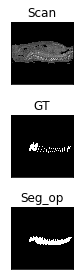

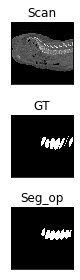

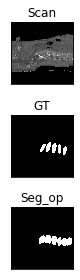

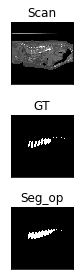

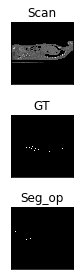

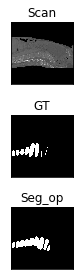

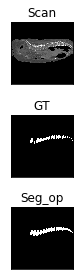

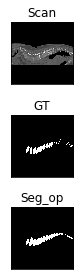

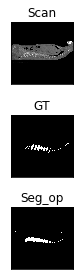

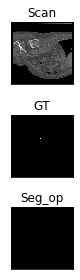

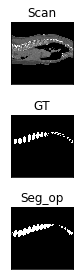

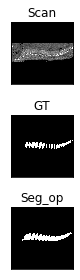

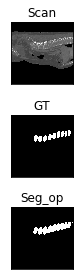

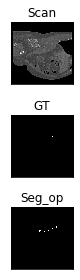

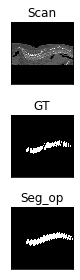

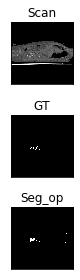

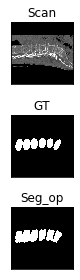

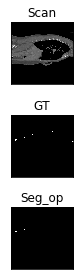

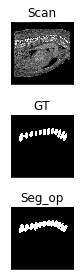

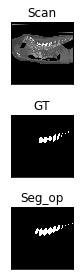

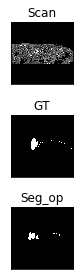

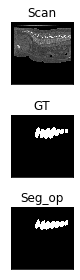

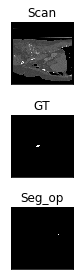

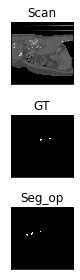

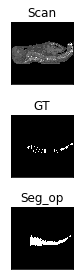

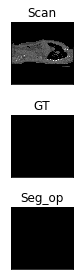

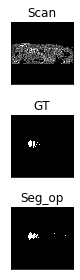

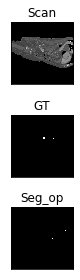

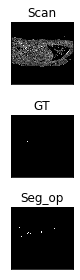

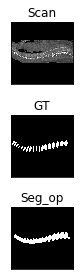

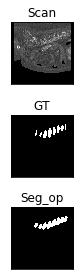

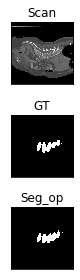

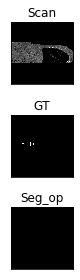

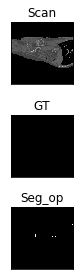

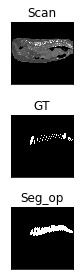

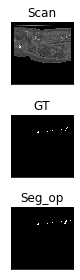

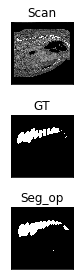

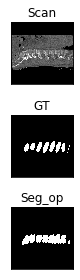

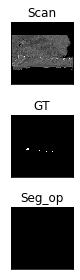

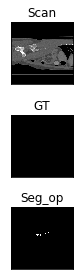

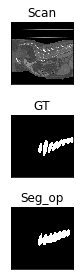

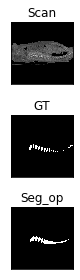

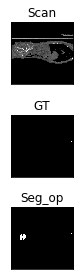

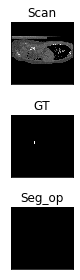

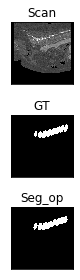

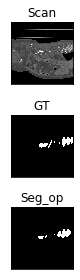

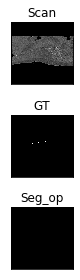

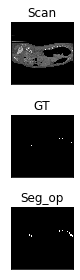

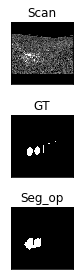

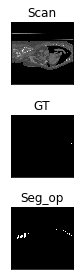

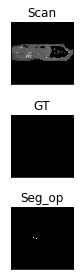

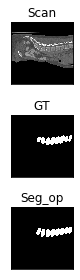

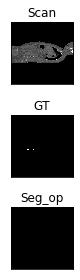

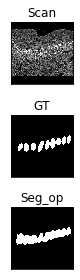

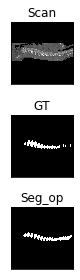

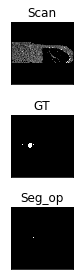

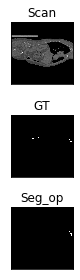

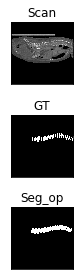

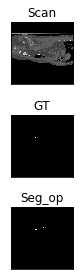

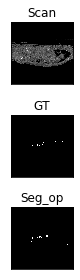

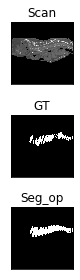

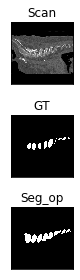

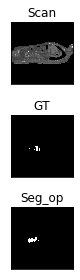

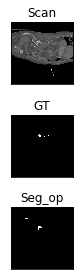

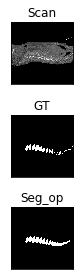

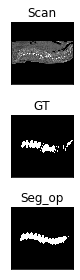

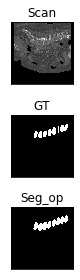

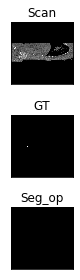

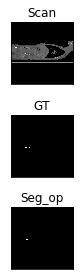

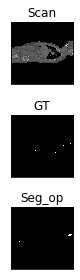

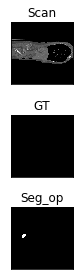

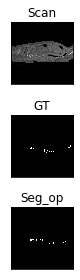

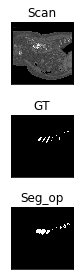

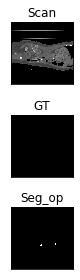

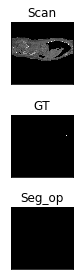

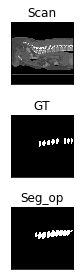

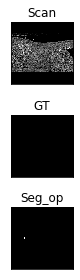

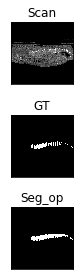

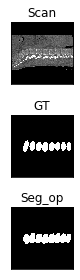

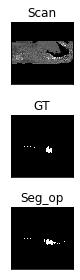

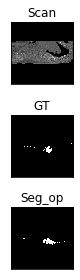

KeyboardInterrupt: 

In [34]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
with torch.no_grad():
    pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
    pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
    for epoch in range(1, epochs+1):
        # print('Epoch: ', epoch)
        model_full.train()
        avg_loss = 0.0
        avg_dscoeff = 0.0
        print('---------- EPOCH:', epoch, '----------')
        print('----------- TRAINING -------------')
        pbar_inner1 = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
        count = 0
        dscoeffs = []
        for i, batch in enumerate(train_loader):
            count+=1
            optimizer_full.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch['img']).to(device)
            segs = Variable(batch['seg'].type(torch.LongTensor)).to(device)
            outputs = model_full(input_img)
            # print(torch.argmax(outputs, 1).shape)
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            optimizer_full.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            dscoeffs.append(dscoeff)
            
            
            if (count%10==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs[0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs[0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # losses1.append(loss.item())
            # dscoeffs.append(dscoeff)
            avg_loss += loss.item()
            avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner1.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
            pbar_inner1.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
        # print(np.array(dscoeffs).shape)
        dscoeffs.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
        avg_losses.append(avg_loss/len(train_loader))
        avg_dscoeffs.append(avg_dscoeff/len(train_loader))
        pbar_outer.update(epoch)
        pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
    #         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
    #         pbar.update(i)

        print('-------------- DONE --------------')
        # model0.eval()
        val_avg_loss = 0.0
        val_avg_dscoeff = 0.0
        print('---------- VALIDATING ------------')
        pbar_inner2 = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)

        count = 0
        val_dscoeffs = []
        for i, batch in enumerate(validation_loader):
            with torch.no_grad():
                count+=1
                # optimizer.zero_grad()
        #         print(len(batch[0]))
                input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
                segs = Variable(batch[1][0].unsqueeze(0).type(torch.LongTensor)).to(device)
                outputs = model_full(input_img)
                # print(outputs.shape)
                # print(torch.unique(torch.argmax(outputs, 1)))
                
                loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
                # loss.backward()os.rmdir
                # optimizer.step()
                dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
                
                val_dscoeffs.append(dscoeff)
                
                # print(torch.unique(outs))
        #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
                if (count%10==1):
                    fig = plt.figure()
                    plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                    plt.subplot(3,1,1).set_title('Scan')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplot(3,1,2).imshow(segs[0].squeeze().cpu().numpy(), cmap='gray')
                    plt.subplot(3,1,2).set_title('GT')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplot(3,1,3).imshow(outs[0].squeeze().cpu().numpy(), cmap='gray')
                    plt.subplot(3,1,3).set_title('Seg_op')
                    plt.xticks([])
                    plt.yticks([])
                    plt.tight_layout()
                    plt.show()
                # val_losses.append(loss.item())
                # val_dscoeffs.append(dscoeff)
                val_avg_loss += loss.item()
                val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
                pbar_inner2.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
                pbar_inner2.update(batch_size)
                pbar_outer.set_description("Epoch count: {}".format(epoch))
        val_dscoeffs.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
        val_avg_dscoeffs.append(val_avg_dscoeff/len(validation_loader))
        val_avg_losses.append(val_avg_loss/len(validation_loader))
        pbar_outer.update(epoch)
        pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))
        filepath = '../prior_models/saved_model_prior_UNet_full_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
        torch.save(model_full.state_dict(), filepath)

In [14]:
print(dscoeffs[-1])
print(val_dscoeffs[-1])

[0.99287833 0.83839876]
[0.97981097 0.6657239 ]


In [15]:
final_avg = np.array(val_avg_dscoeffs)
max_epoch = np.where(final_avg==np.max(final_avg))
max_epoch[0][0]

14

In [16]:
file = '../prior_models/saved_model_prior_UNet_full_'+str(max_epoch[0][0]+1)+'_'+str(train_ratio)+'_SP.pt'
os.replace(file, '../prior_models/best_model/saved_model_prior_UNet_full_'+str(max_epoch[0][0]+1)+'_'+str(train_ratio)+'_SP.pt')

In [17]:
mypath = '../prior_models'
for root, dirs, files in os.walk(mypath):
    if root == '../prior_models':
        for file in files:
            if ('best_model' not in file):
                os.remove(os.path.join(root, file))

In [18]:
print(val_dscoeffs[max_epoch[0][0]])
print(final_avg[max_epoch[0][0]])

[0.9820305705070496, 0.7718631029129028]
0.8364734200572114


In [19]:
# Prior left hippocampus

epochs = 20
batch_size = 1
num_classes = 2
losses1 = []

dscoeffs = []
val_losses = []
val_dscoeffs = []
avg_losses = []
val_avg_losses = []
avg_dscoeffs = []
val_avg_dscoeffs = []

model_left = UNet2D(2, 1).to(device)
optimizer_left = optim.Adam(model_left.parameters(), lr = 0.0001)

In [20]:
params = model_left.state_dict()
for item in params:
    if params[item].type() == 'torch.cuda.FloatTensor':
        params[item].requires_grad = True
    if (params[item].requires_grad == True):
        print(item, params[item].requires_grad)

encoder_block0.conv_block1.conv1.weight True
encoder_block0.conv_block1.conv1.bias True
encoder_block0.conv_block1.conv1_bn.weight True
encoder_block0.conv_block1.conv1_bn.bias True
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv2.weight True
encoder_block0.conv_block1.conv2.bias True
encoder_block0.conv_block1.conv2_bn.weight True
encoder_block0.conv_block1.conv2_bn.bias True
encoder_block0.conv_block1.conv2_bn.running_mean True
encoder_block0.conv_block1.conv2_bn.running_var True
encoder_block1.conv_block1.conv1.weight True
encoder_block1.conv_block1.conv1.bias True
encoder_block1.conv_block1.conv1_bn.weight True
encoder_block1.conv_block1.conv1_bn.bias True
encoder_block1.conv_block1.conv1_bn.running_mean True
encoder_block1.conv_block1.conv1_bn.running_var True
encoder_block1.conv_block1.conv2.weight True
encoder_block1.conv_block1.conv2.bias True
encoder_block1.conv_block1.conv2_bn.weight Tr

In [27]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model_left.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner1 = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer_left.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
        segs = Variable(batch[2][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        outputs = model_left(input_img)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer_left.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner1.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner1.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses.append(avg_loss/len(train_loader))
    avg_dscoeffs.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner2 = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)

    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
            segs = Variable(batch[2][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            outputs = model_left(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()os.rmdir
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner2.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner2.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))
    filepath = '../prior_models/saved_model_prior_UNet_left_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
    torch.save(model_left.state_dict(), filepath)

NameError: name 'model_left' is not defined

In [22]:
print(dscoeffs[-1])
print(val_dscoeffs[-1])

[0.99722724 0.87295483]
[0.99328308 0.74947254]


In [23]:
final_avg = np.array(val_avg_dscoeffs)
max_epoch = np.where(final_avg==np.max(final_avg))
max_epoch[0][0]

8

In [24]:
file = '../prior_models/saved_model_prior_UNet_left_'+str(max_epoch[0][0]+1)+'_'+str(train_ratio)+'_SP.pt'
os.replace(file, '../prior_models/best_model/saved_model_prior_UNet_left_'+str(max_epoch[0][0]+1)+'_'+str(train_ratio)+'_SP.pt')

In [25]:
mypath = '../prior_models'
for root, dirs, files in os.walk(mypath):
    if root == '../prior_models':
        for file in files:
            if ('best_model' not in file):
                os.remove(os.path.join(root, file))

In [26]:
# Prior right hippocampus

epochs = 20
batch_size = 1
num_classes = 2
losses1 = []

dscoeffs = []
val_losses = []
val_dscoeffs = []
avg_losses = []
val_avg_losses = []
avg_dscoeffs = []
val_avg_dscoeffs = []

model_right = UNet2D(2, 1).to(device)
optimizer_right = optim.Adam(model_right.parameters(), lr = 0.0001)

In [27]:
params = model_right.state_dict()
for item in params:
    if params[item].type() == 'torch.cuda.FloatTensor':
        params[item].requires_grad = True
    if (params[item].requires_grad == True):
        print(item, params[item].requires_grad)

encoder_block0.conv_block1.conv1.weight True
encoder_block0.conv_block1.conv1.bias True
encoder_block0.conv_block1.conv1_bn.weight True
encoder_block0.conv_block1.conv1_bn.bias True
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv2.weight True
encoder_block0.conv_block1.conv2.bias True
encoder_block0.conv_block1.conv2_bn.weight True
encoder_block0.conv_block1.conv2_bn.bias True
encoder_block0.conv_block1.conv2_bn.running_mean True
encoder_block0.conv_block1.conv2_bn.running_var True
encoder_block1.conv_block1.conv1.weight True
encoder_block1.conv_block1.conv1.bias True
encoder_block1.conv_block1.conv1_bn.weight True
encoder_block1.conv_block1.conv1_bn.bias True
encoder_block1.conv_block1.conv1_bn.running_mean True
encoder_block1.conv_block1.conv1_bn.running_var True
encoder_block1.conv_block1.conv2.weight True
encoder_block1.conv_block1.conv2.bias True
encoder_block1.conv_block1.conv2_bn.weight Tr

---------- EPOCH: 1 ----------
----------- TRAINING -------------


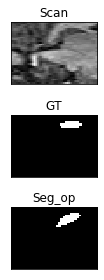

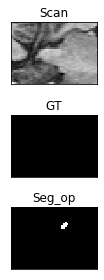

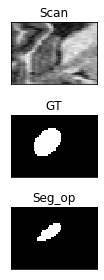

-------------- DONE --------------
---------- VALIDATING ------------


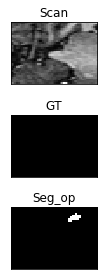

---------- EPOCH: 2 ----------
----------- TRAINING -------------


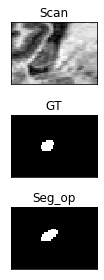

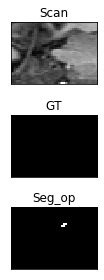

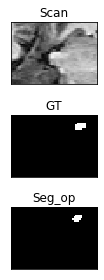

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 3 ----------
----------- TRAINING -------------


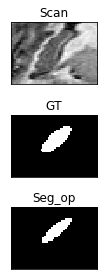

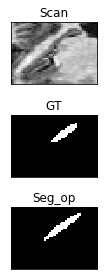

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 4 ----------
----------- TRAINING -------------


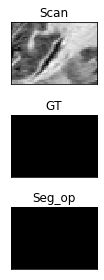

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 5 ----------
----------- TRAINING -------------


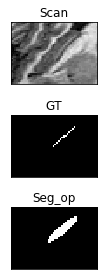

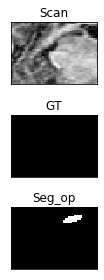

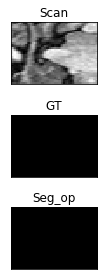

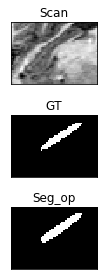

-------------- DONE --------------
---------- VALIDATING ------------


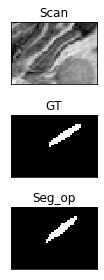

---------- EPOCH: 6 ----------
----------- TRAINING -------------


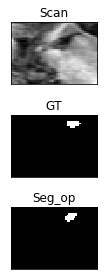

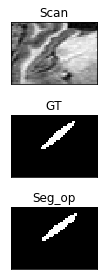

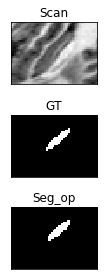

-------------- DONE --------------
---------- VALIDATING ------------


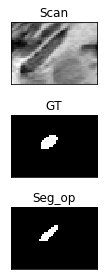

---------- EPOCH: 7 ----------
----------- TRAINING -------------


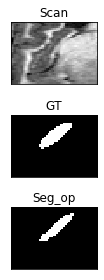

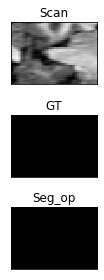

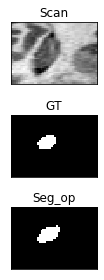

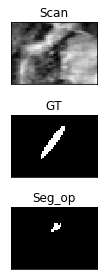

-------------- DONE --------------
---------- VALIDATING ------------


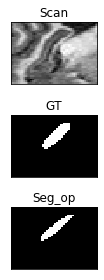

---------- EPOCH: 8 ----------
----------- TRAINING -------------


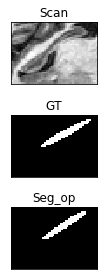

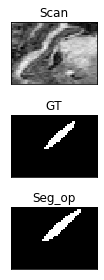

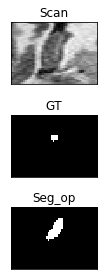

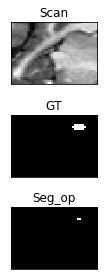

-------------- DONE --------------
---------- VALIDATING ------------


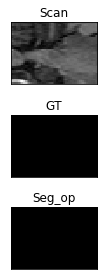

---------- EPOCH: 9 ----------
----------- TRAINING -------------


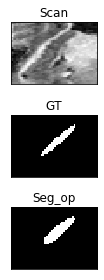

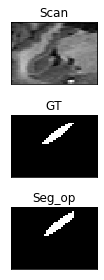

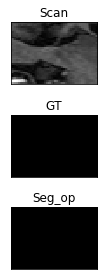

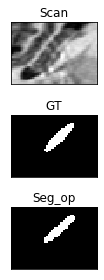

-------------- DONE --------------
---------- VALIDATING ------------


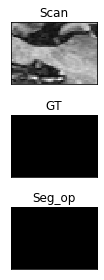

---------- EPOCH: 10 ----------
----------- TRAINING -------------


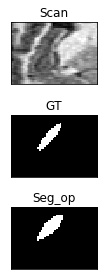

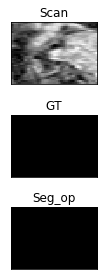

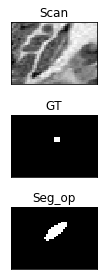

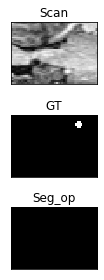

-------------- DONE --------------
---------- VALIDATING ------------


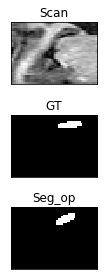

---------- EPOCH: 11 ----------
----------- TRAINING -------------


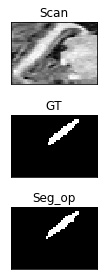

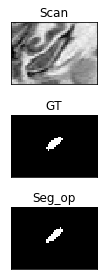

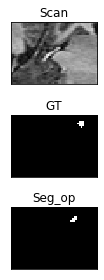

-------------- DONE --------------
---------- VALIDATING ------------


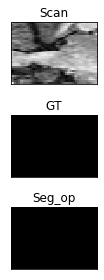

---------- EPOCH: 12 ----------
----------- TRAINING -------------


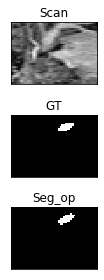

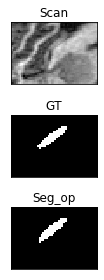

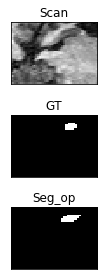

-------------- DONE --------------
---------- VALIDATING ------------


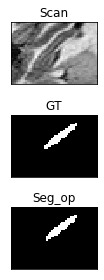

---------- EPOCH: 13 ----------
----------- TRAINING -------------


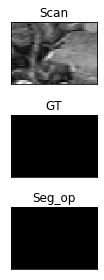

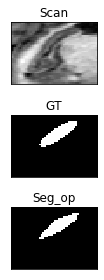

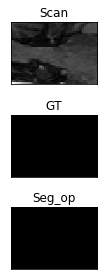

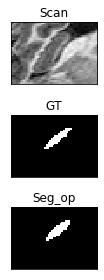

-------------- DONE --------------
---------- VALIDATING ------------


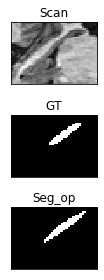

---------- EPOCH: 14 ----------
----------- TRAINING -------------


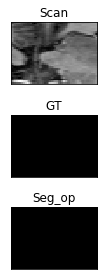

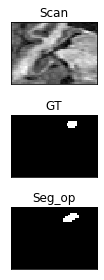

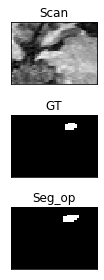

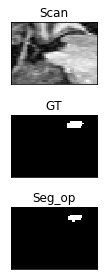

-------------- DONE --------------
---------- VALIDATING ------------


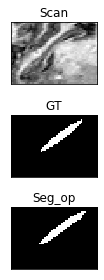

---------- EPOCH: 15 ----------
----------- TRAINING -------------


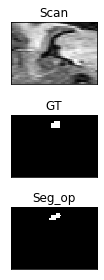

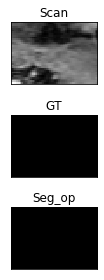

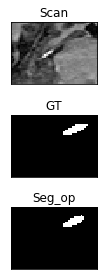

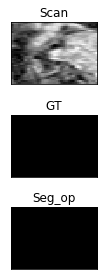

-------------- DONE --------------
---------- VALIDATING ------------


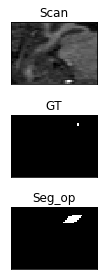

---------- EPOCH: 16 ----------
----------- TRAINING -------------


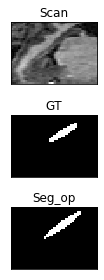

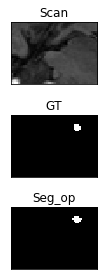

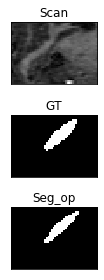

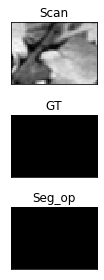

-------------- DONE --------------
---------- VALIDATING ------------


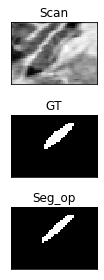

---------- EPOCH: 17 ----------
----------- TRAINING -------------


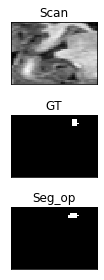

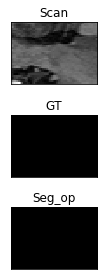

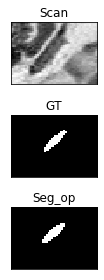

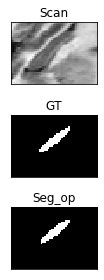

-------------- DONE --------------
---------- VALIDATING ------------


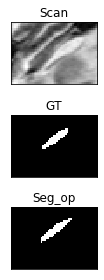

---------- EPOCH: 18 ----------
----------- TRAINING -------------


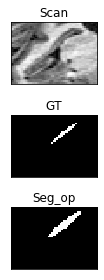

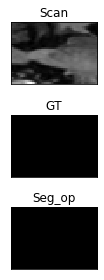

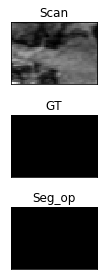

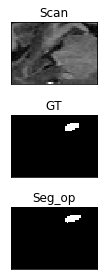

-------------- DONE --------------
---------- VALIDATING ------------


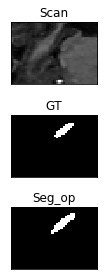

---------- EPOCH: 19 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 20 ----------
----------- TRAINING -------------


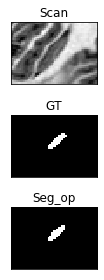

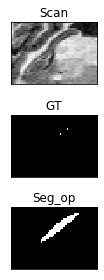

-------------- DONE --------------
---------- VALIDATING ------------


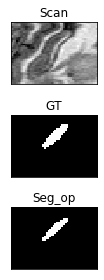

In [28]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model_right.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner1 = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer_right.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
        segs = Variable(batch[3][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        outputs = model_right(input_img)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer_right.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner1.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner1.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses.append(avg_loss/len(train_loader))
    avg_dscoeffs.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner2 = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)

    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
            segs = Variable(batch[3][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            outputs = model_right(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()os.rmdir
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner2.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner2.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))
    filepath = '../prior_models/saved_model_prior_UNet_left_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
    torch.save(model_right.state_dict(), filepath)

In [29]:
print(dscoeffs[-1])
print(val_dscoeffs[-1])

[0.9967563  0.87096942]
[0.99362867 0.75974767]


In [30]:
final_avg = np.array(val_avg_dscoeffs)
max_epoch = np.where(final_avg==np.max(final_avg))
max_epoch[0][0]

15

In [31]:
file = '../prior_models/saved_model_prior_UNet_left_'+str(max_epoch[0][0]+1)+'_'+str(train_ratio)+'_SP.pt'
os.replace(file, '../prior_models/best_model/saved_model_prior_UNet_right_'+str(max_epoch[0][0]+1)+'_'+str(train_ratio)+'_SP.pt')

In [32]:
mypath = '../prior_models'
for root, dirs, files in os.walk(mypath):
    if root == '../prior_models':
        for file in files:
            if ('best_model' not in file):
                os.remove(os.path.join(root, file))

In [33]:
# Prior complete hippocampus

epochs = 20
batch_size = 1
num_classes = 3
losses1 = []

dscoeffs = []
val_losses = []
val_dscoeffs = []
avg_losses = []
val_avg_losses = []
avg_dscoeffs = []
val_avg_dscoeffs = []

model_comp = UNet2D(3, 1).to(device)
optimizer_comp = optim.Adam(model_comp.parameters(), lr = 0.0001)

In [34]:
params = model_comp.state_dict()
for item in params:
    if params[item].type() == 'torch.cuda.FloatTensor':
        params[item].requires_grad = True
    if (params[item].requires_grad == True):
        print(item, params[item].requires_grad)

encoder_block0.conv_block1.conv1.weight True
encoder_block0.conv_block1.conv1.bias True
encoder_block0.conv_block1.conv1_bn.weight True
encoder_block0.conv_block1.conv1_bn.bias True
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv2.weight True
encoder_block0.conv_block1.conv2.bias True
encoder_block0.conv_block1.conv2_bn.weight True
encoder_block0.conv_block1.conv2_bn.bias True
encoder_block0.conv_block1.conv2_bn.running_mean True
encoder_block0.conv_block1.conv2_bn.running_var True
encoder_block1.conv_block1.conv1.weight True
encoder_block1.conv_block1.conv1.bias True
encoder_block1.conv_block1.conv1_bn.weight True
encoder_block1.conv_block1.conv1_bn.bias True
encoder_block1.conv_block1.conv1_bn.running_mean True
encoder_block1.conv_block1.conv1_bn.running_var True
encoder_block1.conv_block1.conv2.weight True
encoder_block1.conv_block1.conv2.bias True
encoder_block1.conv_block1.conv2_bn.weight Tr

---------- EPOCH: 1 ----------
----------- TRAINING -------------


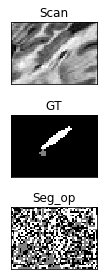

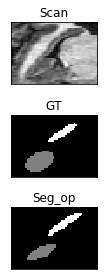

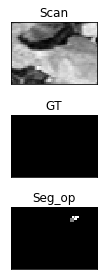

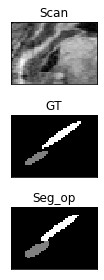

-------------- DONE --------------
---------- VALIDATING ------------


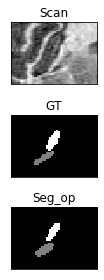

---------- EPOCH: 2 ----------
----------- TRAINING -------------


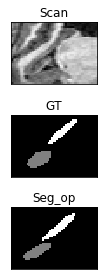

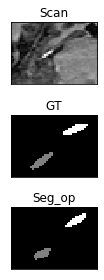

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 3 ----------
----------- TRAINING -------------


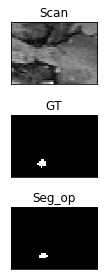

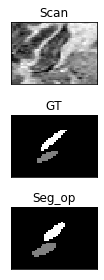

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 4 ----------
----------- TRAINING -------------


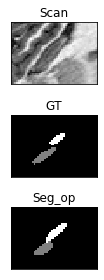

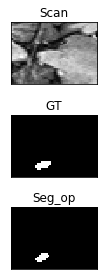

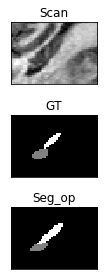

-------------- DONE --------------
---------- VALIDATING ------------


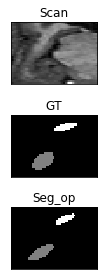

---------- EPOCH: 5 ----------
----------- TRAINING -------------


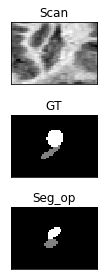

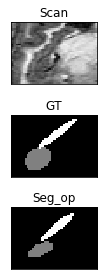

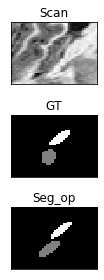

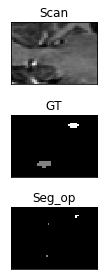

-------------- DONE --------------
---------- VALIDATING ------------


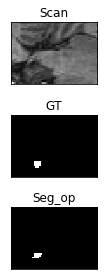

---------- EPOCH: 6 ----------
----------- TRAINING -------------


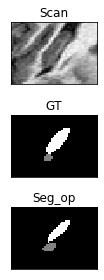

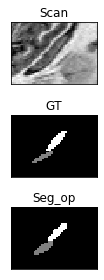

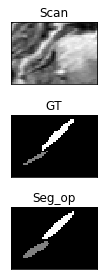

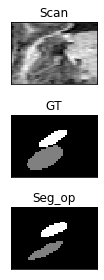

-------------- DONE --------------
---------- VALIDATING ------------


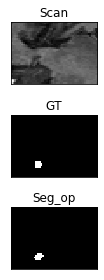

---------- EPOCH: 7 ----------
----------- TRAINING -------------


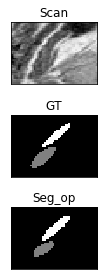

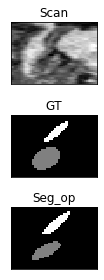

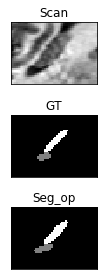

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 8 ----------
----------- TRAINING -------------


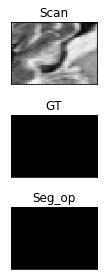

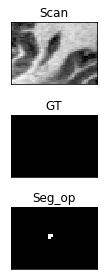

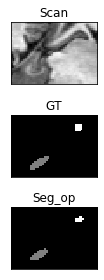

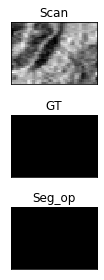

-------------- DONE --------------
---------- VALIDATING ------------


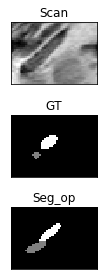

---------- EPOCH: 9 ----------
----------- TRAINING -------------


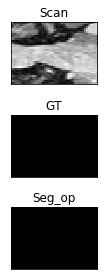

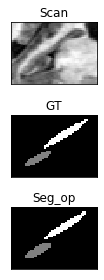

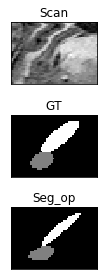

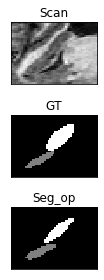

-------------- DONE --------------
---------- VALIDATING ------------


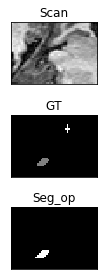

---------- EPOCH: 10 ----------
----------- TRAINING -------------


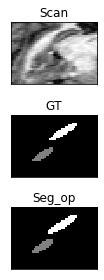

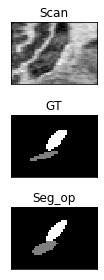

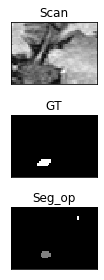

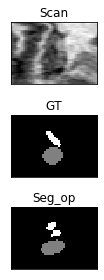

-------------- DONE --------------
---------- VALIDATING ------------


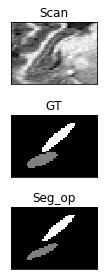

---------- EPOCH: 11 ----------
----------- TRAINING -------------


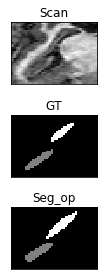

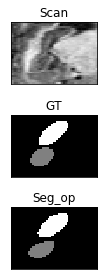

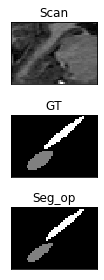

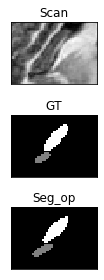

-------------- DONE --------------
---------- VALIDATING ------------


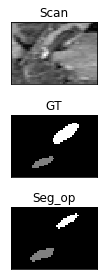

---------- EPOCH: 12 ----------
----------- TRAINING -------------


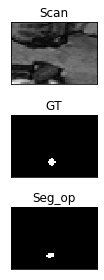

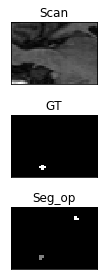

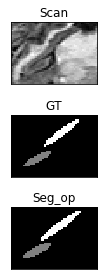

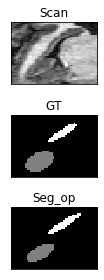

-------------- DONE --------------
---------- VALIDATING ------------


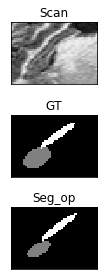

---------- EPOCH: 13 ----------
----------- TRAINING -------------


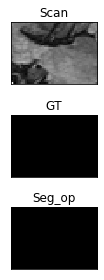

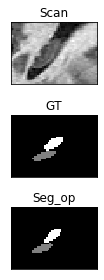

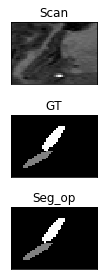

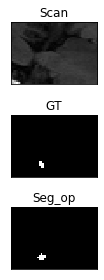

-------------- DONE --------------
---------- VALIDATING ------------


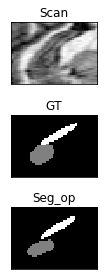

---------- EPOCH: 14 ----------
----------- TRAINING -------------


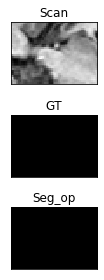

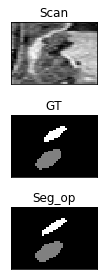

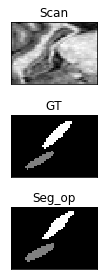

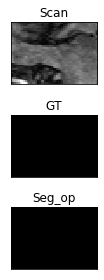

-------------- DONE --------------
---------- VALIDATING ------------


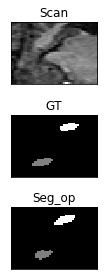

---------- EPOCH: 15 ----------
----------- TRAINING -------------


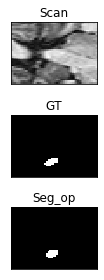

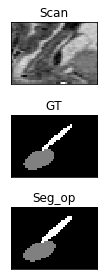

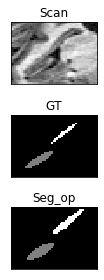

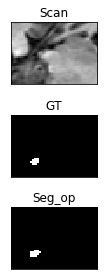

-------------- DONE --------------
---------- VALIDATING ------------


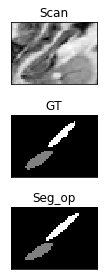

---------- EPOCH: 16 ----------
----------- TRAINING -------------


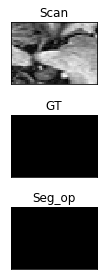

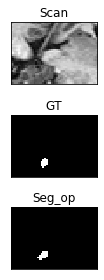

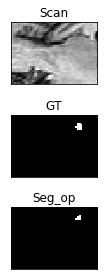

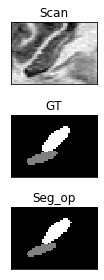

-------------- DONE --------------
---------- VALIDATING ------------


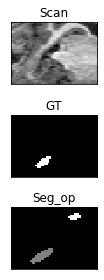

---------- EPOCH: 17 ----------
----------- TRAINING -------------


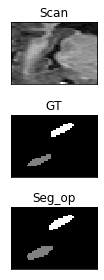

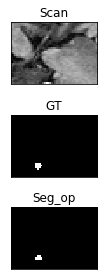

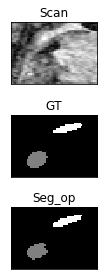

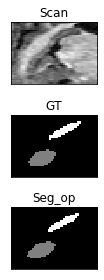

-------------- DONE --------------
---------- VALIDATING ------------


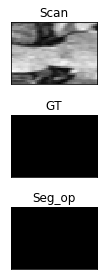

---------- EPOCH: 18 ----------
----------- TRAINING -------------


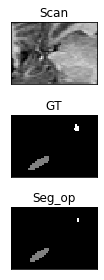

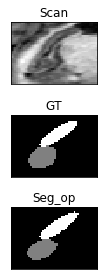

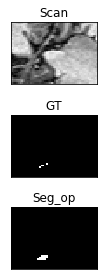

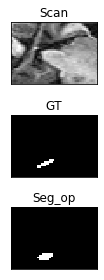

-------------- DONE --------------
---------- VALIDATING ------------


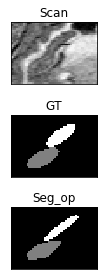

---------- EPOCH: 19 ----------
----------- TRAINING -------------


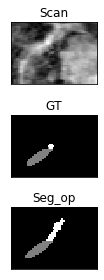

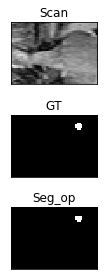

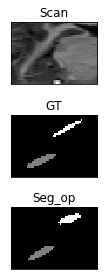

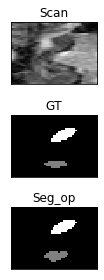

-------------- DONE --------------
---------- VALIDATING ------------


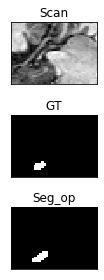

---------- EPOCH: 20 ----------
----------- TRAINING -------------


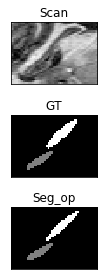

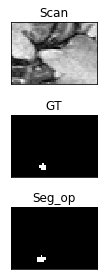

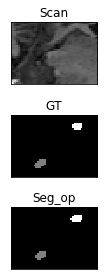

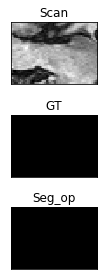

-------------- DONE --------------
---------- VALIDATING ------------


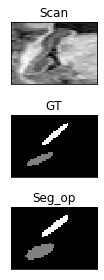

In [35]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model_comp.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner1 = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer_comp.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
        segs = Variable(batch[4][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        outputs = model_comp(input_img)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer_comp.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner1.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner1.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses.append(avg_loss/len(train_loader))
    avg_dscoeffs.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner2 = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)

    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
            segs = Variable(batch[4][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            outputs = model_comp(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()os.rmdir
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner2.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner2.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))
    filepath = '../prior_models/saved_model_prior_UNet_comp_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
    torch.save(model_comp.state_dict(), filepath)

In [36]:
final_avg = np.array(val_avg_dscoeffs)
max_epoch = np.where(final_avg==np.max(final_avg))
max_epoch[0][0]

10

In [37]:
file = '../prior_models/saved_model_prior_UNet_comp_'+str(max_epoch[0][0]+1)+'_'+str(train_ratio)+'_SP.pt'
os.replace(file, '../prior_models/best_model/saved_model_prior_UNet_comp_'+str(max_epoch[0][0]+1)+'_'+str(train_ratio)+'_SP.pt')

In [38]:
mypath = '../prior_models'
for root, dirs, files in os.walk(mypath):
    if root == '../prior_models':
        for file in files:
            if ('best_model' not in file):
                os.remove(os.path.join(root, file))

In [14]:
model_comp = UNet2D(3, 1).to(device)
model_comp.load_state_dict(torch.load('../prior_models/best_model/saved_model_prior_UNet_comp_11_1.0_SP.pt', map_location=torch.device("cuda:0")))

model_left = UNet2D(2, 1).to(device)
model_left.load_state_dict(torch.load('../prior_models/best_model/saved_model_prior_UNet_left_9_1.0_SP.pt', map_location=torch.device("cuda:0")))

model_right = UNet2D(2, 1).to(device)
model_right.load_state_dict(torch.load('../prior_models/best_model/saved_model_prior_UNet_right_16_1.0_SP.pt', map_location=torch.device("cuda:0")))

model_full = UNet2D(2, 1).to(device)
model_full.load_state_dict(torch.load('../prior_models/best_model/saved_model_prior_UNet_full_15_1.0_SP.pt', map_location=torch.device("cuda:0")))

<All keys matched successfully>

In [12]:
def get_prior(model, img):
    with torch.no_grad():
        outputs = model(img)
        outputs = torch.argmax(outputs, dim=1)
    return outputs

In [13]:
a = iter(train_loader)
batch = a.next()
input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
segs = Variable(batch[1][0].unsqueeze(0).type(torch.LongTensor)).to(device)

In [15]:
output_comp = get_prior(model_comp, input_img)
output_left = get_prior(model_left, input_img)
output_right = get_prior(model_right, input_img)
output_full = get_prior(model_full, input_img)

In [32]:
def plot_priors(img, full_prior, left_prior, right_prior, left_right_prior):
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,5,1).imshow(img, cmap='gray')
    plt.subplot(1,5,1).set_title('Model Input', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,2).imshow(full_prior, cmap='gray')
    plt.subplot(1,5,2).set_title('Full Model Prior', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,3).imshow(left_prior, cmap='gray')
    plt.subplot(1,5,3).set_title('Ant Model Prior', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,4).imshow(right_prior, cmap='gray')
    plt.subplot(1,5,4).set_title('Post Model Prior', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,5).imshow(left_right_prior, cmap='gray')
    plt.subplot(1,5,5).set_title('Complete Model Prior', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

/home/rahul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/rahul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/rahul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous 

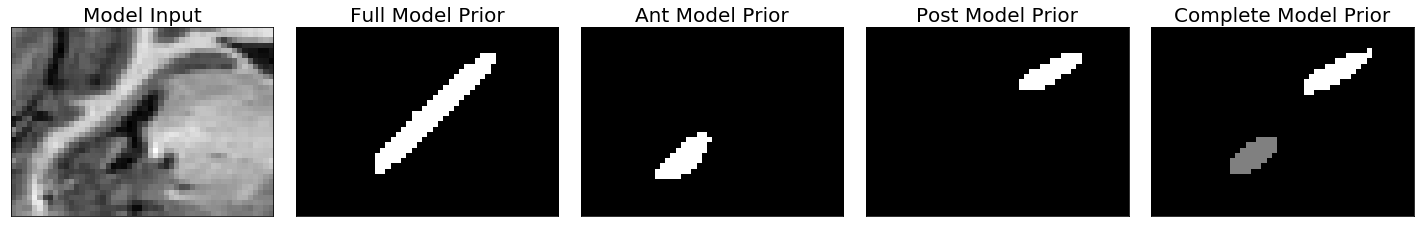

In [33]:
plot_priors(input_img.squeeze().detach().cpu().numpy(), output_full.squeeze().detach().cpu().numpy(), \
    output_left.squeeze().detach().cpu().numpy(), output_right.squeeze().detach().cpu().numpy(), output_comp.squeeze().detach().cpu().numpy())

In [ ]:
def plot_priors(img, full_prior, left_prior, right_prior, left_right_prior):
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,5,1).imshow(img, cmap='gray')
    plt.subplot(1,5,1).set_title('Model Input', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,2).imshow(full_prior, cmap='gray')
    plt.subplot(1,5,2).set_title('Full Model Prior', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,3).imshow(left_prior, cmap='gray')
    plt.subplot(1,5,3).set_title('Ant Model Prior', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,4).imshow(right_prior, cmap='gray')
    plt.subplot(1,5,4).set_title('Post Model Prior', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,5).imshow(left_right_prior, cmap='gray')
    plt.subplot(1,5,5).set_title('Complete Model Prior', fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()